# The rise of Newsletter Spam: A journey through my Gmail inbox

![title](img/searchdontsort.jpg)
In the beginning there was spam. Cheap, unpersonalised, mass-send junk mail, easily defeated by simple [Bayesian Filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering). Over the years spammers improved and an arms race between spammers and spam filters was started. Spam was to me never more then a minor nuisance, and when gmail was launched, and all of google's might was put into the race spam in your inbox became virtually extinct. Now I don't even remember what an email for "ch3aP V1agrA" email looks like. 

Does this mean my inbox is empty? No. In fact I feel I receive more unwanted mail then ever. With the internet being more and more intertwined in our lives, we drop our email addresses with more and more companies, whom in turn have started sending "promotions", and "updates" more and more frequent. Even though they usually contain an "unsubscribe" option which I sometimes spend some time clicking though, these mailing lists have become a bigger source of irritation then spam ever was.

This jupyter notebook started out as a way to regularly delete all "Newsletter spam" from my inbox. It turned out however, to be a lot more fun to dig through my gmail inbox, which is what this post is mostly about. I would recommend everyone reading this to clone this notebook and start the same journey on your own inbox. Viewing stats on my inbox is not that interesting, viewing the same stats on your own inbox? A completely different story. It also gives you a sense on how big mailing list spam has become. Although the Gmail API has a delete option - it went against my Data Scientist instinct to actually delete anything. 

In [1]:
import httplib2
import os
import base64
import numpy as np
import pandas as pd
import datetime
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Any, List, Optional, cast
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

%matplotlib inline
sns.set()

## Connect to the Gmail API
To get our emails, we will use the Gmail API. To to this we first need to enable the Gmail api and download a credential file. In this case I have stored the credential file next to the jupyter notebook. Follow steps 1 and 2 on [this page](https://developers.google.com/gmail/api/quickstart/python#step_1_turn_on_the) to enable the API and get the credential file. 

First we need to connect to the gmail api with the credentials file and build a "Resource" object:

In [3]:
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
creds = flow.run_local_server()
service = build('gmail', 'v1', credentials=creds)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=387053294207-o8go48qp3aqoml2ofb0jfhcnq2suebr2.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.readonly&state=C2WsSMLUnsvyWxxHHgHs4ipSgzRoPY&access_type=offline


This object called _service_ has a set of functions to connect to the API service. The following lists all the labels in my inbox, and is a good test to see if our connection works


In [4]:
labels = service.users().labels().list(userId='me').execute()
[label['name'] for label in labels['labels']]

['Deleted Items',
 'Sent Items',
 '[Imap]/Sent',
 'CATEGORY_PERSONAL',
 'Receipts',
 'IMPORTANT',
 'Travel',
 'CHAT',
 'SENT',
 'INBOX',
 'TRASH',
 'DRAFT',
 'SPAM',
 'STARRED',
 'UNREAD',
 'Personal',
 'CATEGORY_FORUMS',
 'CATEGORY_SOCIAL',
 '[Imap]/Trash',
 'Work',
 'CATEGORY_UPDATES',
 'CATEGORY_PROMOTIONS']

### Loading our data

To download all our emails we can use the _get_ function. This function needs an email id as as input. To get these IDs we need the _users.messages.list_ method. The following function returns a list with all email id's belonging to a specific _label_ (e.g. Inbox, Spam, Sent, etc):

In [5]:
def list_messages_with_labels(service, user_id, label_ids=[]):
    response = service.users().messages().list(userId=user_id,
                                               labelIds=label_ids).execute()
    messages = list()
    if 'messages' in response:
        messages.extend(response['messages'])
        while 'nextPageToken' in response:
            page_token = response['nextPageToken']
            response = service.users().messages().list(userId=user_id,
                                                         labelIds=label_ids,
                                                         pageToken=page_token).execute()
            messages.extend(response['messages'])
    return messages

For the purpose of this post we are just interested in messages in my inbox:

In [6]:
all_email_ids = list_messages_with_labels(service, 'me', 'INBOX')

print(f'I have {format(len(all_email_ids), ",d")} messages in my inbox')

I have 37,950 messages in my inbox


Single events can be retrieved using the _get_ function which returns a dictionary:

In [676]:
event = service.users().messages().get(userId='me', id='168480e9f32d4068').execute()

To parse the output from the mentioned get function, I've created a small "_Email_" class which takes the email dictionary as the input of its constructor, and has the parts of the email we are interested in as its attributes. I've added [type hints](https://blog.jetbrains.com/pycharm/2015/11/python-3-5-type-hinting-in-pycharm-5/) in case this is ever taken out of this notebook and put into a module.

In [7]:
class Email(object):
    def __init__(self, email: dict):
        self._logger = logging.getLogger('Email')
        self.id: str = email['id']
        self.label_ids: List[str] = email.get('labelIds', None)
        self.date: datetime.datetime = datetime.datetime.fromtimestamp(int(email['internalDate'])/1000)
        self.size: int = email['sizeEstimate']
        self.sender: str = None
        self.to: str = None
        self.subject: str = None
            
        if 'headers' in email['payload']:
            self._parse_headers(email)
        else:
            self._logger.warning(f'Headers not found for email with id: {self.id}')
            
        self.__dict__ = self._as_dict()
    
    def _parse_headers(self, email: dict):
        headers = email['payload']['headers']
        for header in headers:
            if header['name'] == 'From':
                self.sender = header['value']
            elif header['name'] == 'To':
                self.to = header['value']
            elif header['name'] == 'Subject':
                self.subject = header['value']
                
    def _as_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
                
        

Now we can fetch a list of emails and convert this to a DataFrame. As we don't want to send and get a new http request for each email we will use the [BatchHttpRequest](https://developers.google.com/api-client-library/python/guide/batch) object. This object allows us to bundle multiple http requests and a _callback_ function that handles the result of the individual requests. The gmail API is rate limited at 250 requests per second - so we will have to create batches of 250 or less requests, and wait one second after each batch request is executed. 

In [8]:
BATCH_SIZE = 200 # Maximum number of requests per second
emails = list() # List of Dictionaries with the emails - will be used as input for our DataFrame

def add_emails(request_id, response, exception):
    """Callback function that handles the result of each request"""
    if exception is not None:
    # Do something with the exception
        raise ValueError(exception)
    else:
    # Convert the email to a dictionary using our Email class
        emails.append(vars(Email(response)))

batch = service.new_batch_http_request()
for i, msg_id in enumerate(all_email_ids):
    batch.add(service.users().messages().get(userId = 'me', id = msg_id['id']), callback=add_emails)
    if i % BATCH_SIZE == 0:
        batch.execute()
        batch = service.new_batch_http_request()
        print(f'{i} out of {len(all_email_ids)} done')
        time.sleep(2)

# Create a DataFrame from our list of emails
all_emails = pd.DataFrame(emails)

0 out of 37950 done
100 out of 37950 done
200 out of 37950 done
300 out of 37950 done
400 out of 37950 done
500 out of 37950 done
600 out of 37950 done
700 out of 37950 done
800 out of 37950 done
900 out of 37950 done
1000 out of 37950 done
1100 out of 37950 done
1200 out of 37950 done
1300 out of 37950 done
1400 out of 37950 done
1500 out of 37950 done
1600 out of 37950 done
1700 out of 37950 done
1800 out of 37950 done
1900 out of 37950 done
2000 out of 37950 done
2100 out of 37950 done
2200 out of 37950 done
2300 out of 37950 done
2400 out of 37950 done
2500 out of 37950 done
2600 out of 37950 done
2700 out of 37950 done
2800 out of 37950 done
2900 out of 37950 done
3000 out of 37950 done
3100 out of 37950 done
3200 out of 37950 done
3300 out of 37950 done
3400 out of 37950 done
3500 out of 37950 done
3600 out of 37950 done
3700 out of 37950 done
3800 out of 37950 done
3900 out of 37950 done
4000 out of 37950 done
4100 out of 37950 done
4200 out of 37950 done
4300 out of 37950 done


Headers not found for email with id: 13ed713debd8d989
Headers not found for email with id: 13ed713be5efe406


18100 out of 37950 done


Headers not found for email with id: 13ed713b1dcb6ac4
Headers not found for email with id: 13ed71398fdfc72d


18200 out of 37950 done
18300 out of 37950 done
18400 out of 37950 done
18500 out of 37950 done
18600 out of 37950 done
18700 out of 37950 done
18800 out of 37950 done
18900 out of 37950 done
19000 out of 37950 done
19100 out of 37950 done
19200 out of 37950 done
19300 out of 37950 done
19400 out of 37950 done
19500 out of 37950 done
19600 out of 37950 done
19700 out of 37950 done
19800 out of 37950 done
19900 out of 37950 done
20000 out of 37950 done
20100 out of 37950 done
20200 out of 37950 done
20300 out of 37950 done
20400 out of 37950 done
20500 out of 37950 done
20600 out of 37950 done
20700 out of 37950 done
20800 out of 37950 done
20900 out of 37950 done
21000 out of 37950 done
21100 out of 37950 done
21200 out of 37950 done
21300 out of 37950 done
21400 out of 37950 done
21500 out of 37950 done
21600 out of 37950 done
21700 out of 37950 done
21800 out of 37950 done
21900 out of 37950 done
22000 out of 37950 done
22100 out of 37950 done
22200 out of 37950 done
22300 out of 379

### Exploring our data
Let's have a look at our newly created DataFrame:

In [3]:
all_emails.head()

,date,id,label_ids,sender,size,subject,to
0,2019-04-06 05:02:13,169f1e24cbfcb6b3,"[UNREAD, CATEGORY_UPDATES, INBOX]",Hendrik Oude Nijhuis <support@warrenbuffett.nl>,6474,YouTube versus Netflix,me@gmail.com
1,2019-04-06 00:59:27,169f1040b804177b,"[UNREAD, CATEGORY_UPDATES, INBOX]",Glassdoor Jobs <noreply@glassdoor.com>,33836,An opportunity for you at OfferUp was just posted,me@gmail.com
2,2019-04-05 19:06:05,169efc086a341584,"[UNREAD, CATEGORY_UPDATES, INBOX]",Seamless <orders@eat.seamless.com>,27193,Your order from Il Baretto is being prepared,me@gmail.com
3,2019-04-05 18:55:03,169efb6e45092d27,"[UNREAD, CATEGORY_UPDATES, INBOX]",New York Road Runners <email@nyrrmailing.org>,77285,Join Us for Three New Virtual Races,me@gmail.com
4,2019-04-05 18:36:39,169efa595456b40d,"[CATEGORY_SOCIAL, INBOX]",Quora Digest <digest-noreply@quora.com>,123952,A senior software engineer told me that functi...,me@gmail.com


We can now use this DataFrame to dig through our emails. For example calculate the total size of our inbox in gigabytes:

In [97]:
all_emails['size'].sum() / 1024 ** 3

4.190045651048422

Or find out the biggest email in our inbox - in this case a 34MB email with pictures from a Rafting trip in 2011. Fun times!

In [21]:
all_emails[all_emails['size'] == max(all_emails['size'])]

,id,label_ids,sender,size,subject,to,sender_norm,anon,size_mb
date,,,,,,,,,
2011-10-22 19:36:15,1332dff678ef6b13,"[CATEGORY_PERSONAL, INBOX]",Some guy,35686503,Rangitata Rafts Pics,Me,NaN,NaN,34.033301


This is an obvious outlier - most emails are much smaller:

The median size is only 15.03 kb


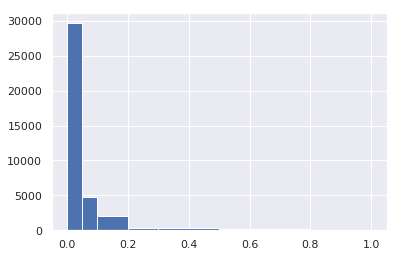

In [22]:
# Add a column with sizes in Mb - which is easier to read
all_emails['size_mb'] = all_emails['size'] / 1024 ** 2

_ = plt.hist(all_emails['size_mb'], bins=[0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1])
print(f'The median size is only {(all_emails["size"].median() / 1024):.2f} kb')

Now lets see who our most frequent senders are. First we want to clean up the adresses a bit and strip out only the actuall email adress:

In [17]:
all_emails['sender_norm'] = (all_emails['sender']
                           .str.extract('<?(\S+@\S+.\w+)>?', expand=False)
                           .str.lower()
                           .str.replace('"', '')
                           .str.replace('<', '')
                           .str.replace('[', ''))

To see who the top senders are we can group by this new column and calculate the number of emails recieved from this person (_count_) and the total size of all emails send by this person (_sum_ of size_mb)

In [23]:

top_senders = (all_emails.groupby('sender_norm')
           .agg({'sender_norm': ['count'], 'size_mb' : ['sum']})
           .sort_values(by=[('sender_norm', 'count')], ascending=False))

# Check the 10 senders that send most emails
top_senders.head(10)

,sender_norm,size_mb
,count,sum
sender_norm,,
ns-vertraging@ns-vertragingsmail.com,1374,6.865120
digest-noreply@quora.com,960,95.993297
info@meetup.com,730,41.120080
Family,697,185.316703
notification+orpefvl1@facebookmail.com,695,6.315460
Friend 1,657,48.461307
Friend 2,650,88.133715
Wife,628,231.473106


I've anonymised most of the senders for obvious reasons. I'm glad too see there are some friends and family members in the top 10, and it's not only newsletters. My number 1 spammer: _ns-vertraging@ns-vertragingsmail.com_ is an automated mail I get when the train I used to take gets delayed, see [this previous blog post](https://bergvca.github.io/2017/02/01/ikbenwatlater.html). As you can see, this train is delayed a lot... It's also good to know that the newsletters are generally much smaller then the emails from friends. If we sort by size we see mostly natural persons in the top 10, me sending myself emails with large attachments being number 1.

In [34]:
top_senders.sort_values(by=[('size_mb', 'sum')], ascending=False).head(10)

,sender_norm,size_mb
,count,sum
sender_norm,,
me@gmail.com,378,300.656649
Wife,628,231.473106
Newsletter 2,517,213.101904
Family,697,185.316703
Friend 3,196,122.931810
Sports club,231,97.326284
digest-noreply@quora.com,960,95.993297
Friend 4,43,94.249075


## Emails over time
Lets calculate the amount of emails received per week. First we need to change the index of the DataFrame to the date column:

In [ ]:
all_emails = all_emails.set_index('date')

Now we need to [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) the DataFrame in weekly periods, and count the number of emails per week. To get a nice and smooth line we will use a rolling average of these counts. To calculate the means we use a gaussian kernel (the function that is used to take the average of the neighboring points).

In [35]:
weekly_counts = all_emails.resample('W').count() # Get a count per week
# filter data from before gmail existed 
weekly_counts = weekly_counts[weekly_counts.index > np.datetime64('2004-04-01')] 
# Calculate the moving average
moving_av = weekly_counts.rolling(10, center=True, win_type='gaussian').mean(std=3)['id']

Now plot this moving average. I'm using the Object Oriented interface of Matplotlib which gives you much more flexibility and and ease of use in the long run.

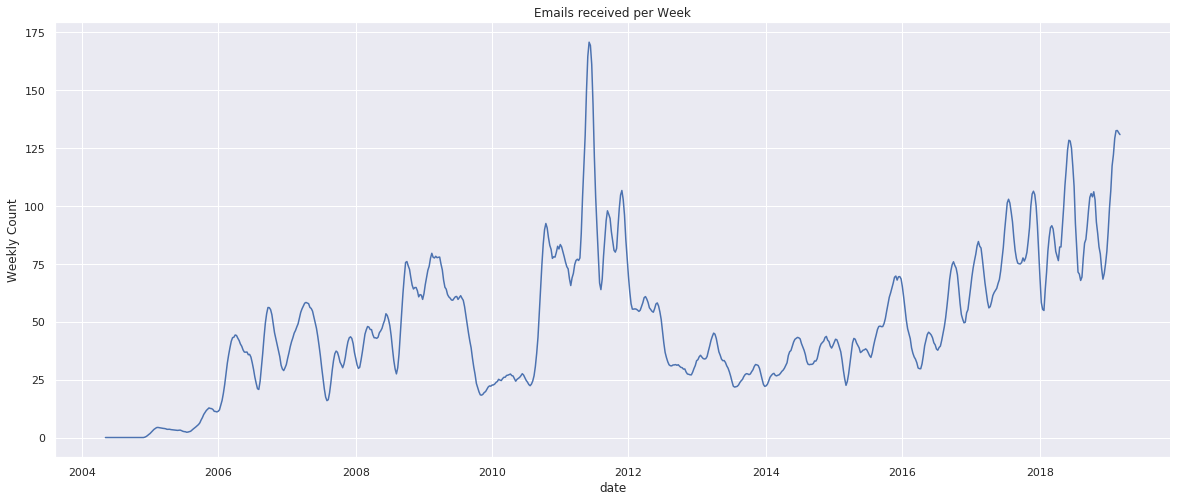

In [36]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='Date', ylabel='Weekly Count',
       title='Emails received per Week')
_ = moving_av.plot(ax=ax) 

Very cool! For the reader this might be "just" a graph, which is why I recommend to clone this notebook and run it on your own data. For me I see a clear period when I was in university, a period when I was not in university and using another email address, a period when I was basically using gmail as a substitute for what is now WhatsApp, and the rise of _newsletter_ spam.

In [37]:
# Filter only emails from the 15 frequent senders:
top_sender_over_time = all_emails[all_emails['sender_norm'].isin(top_senders.head(15).index)]

# Group by sender and month and count
top_sender_over_time = (top_sender_over_time
                        .groupby(['sender_norm', pd.Grouper(level='date', freq='M')])
                        .agg({'sender_norm': ['count']}))

# "Unstack" the sender part of the index, so each sender gets his own column
top_sender_over_time = top_sender_over_time.unstack(level='sender_norm')

# Resample to make sure all periods have a value, even when no emails were recieved in that period
top_sender_over_time = top_sender_over_time.resample('M')

# Calculate the moving average the same way we did before    
top_sender_over_time = (top_sender_over_time.sum()
               .rolling(10, center=True, win_type='gaussian')
               .mean(std=3)
                       )

Our columns now are a MultiIndex with three levels, the first two having just a single value each ('sender_norm', and 'count'). We can remove these to get a cleaner looking plot:

In [38]:
top_sender_over_time = top_sender_over_time['sender_norm']['count']

Let's plot it!

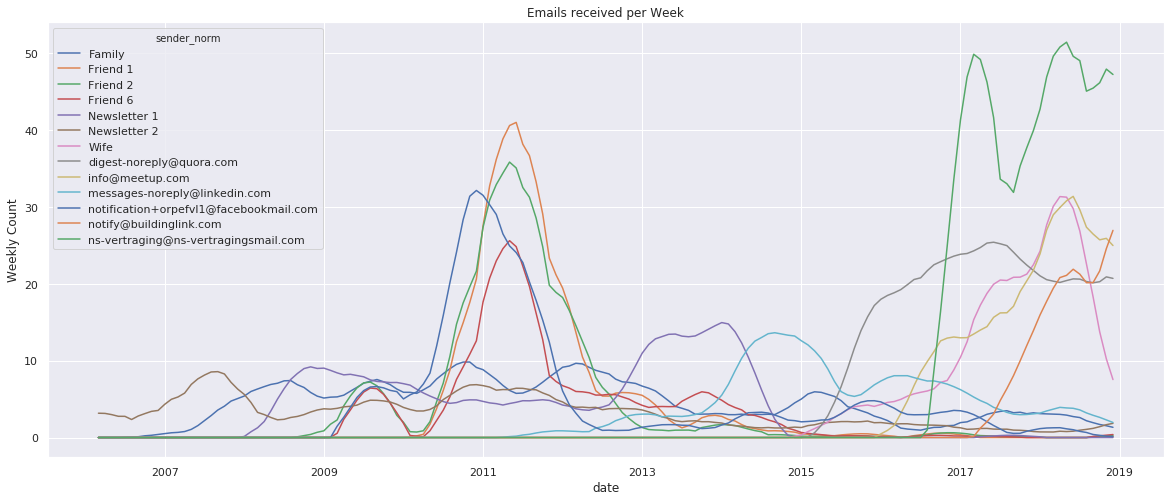

In [39]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='Date', ylabel='Weekly Count',
       title='Emails received per Week')
_ = top_sender_over_time.plot(ax=ax) 

To be honest, it looks like someone threw a plate of spaghetti on my screen... Let's put it in something a little bit more readable, such as a heatmap. We can do this with the excellent Seaborn [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function. We can use this on our DataFrame directly, or transpose our DataFrame to get one were the senders are on the Y-axis and dates on the X-axis:

In [41]:
top_sender_over_time_t = top_sender_over_time.transpose()
top_sender_over_time_t.columns = top_sender_over_time_t.columns.strftime('%Y-%m')

Now create the heatmap:

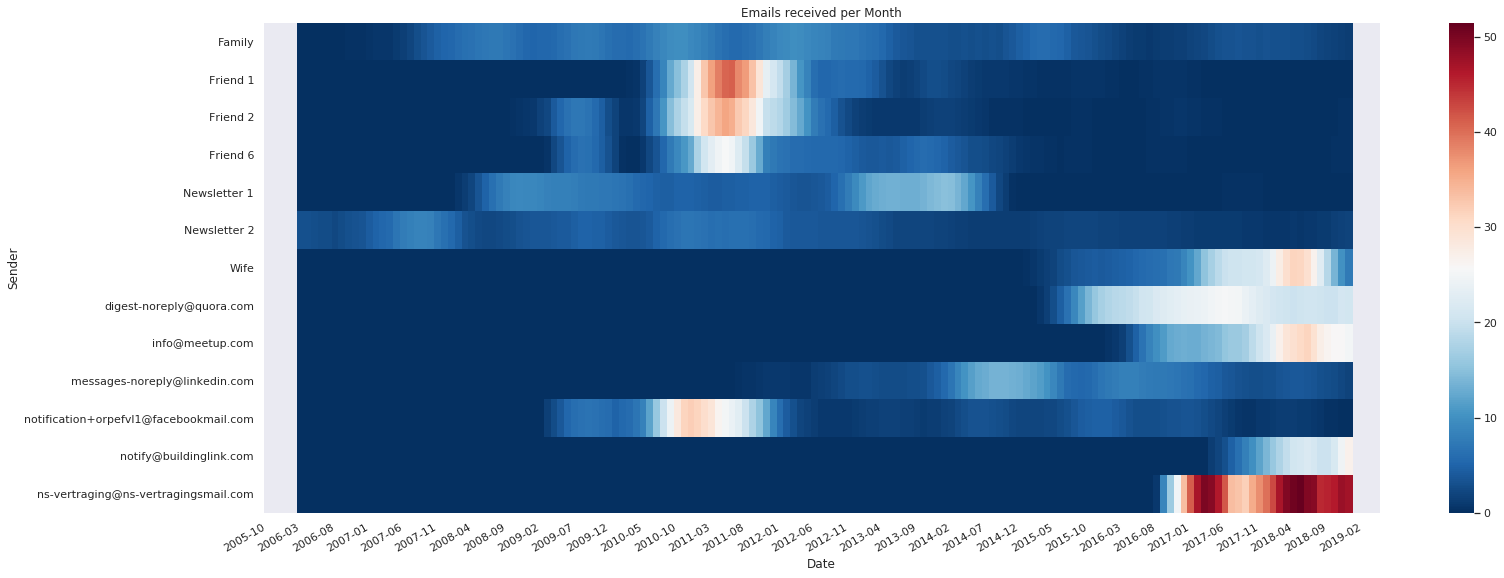

In [42]:
def plot_heatmap(df_to_plot, xlabel, ylabel, title):
    """Plots heatmap based of df_to_plot with some extra formatting"""
    fig, ax = plt.subplots(figsize=(25,10))

    ax = sns.heatmap(df_to_plot, ax=ax, xticklabels=True, cmap="RdBu_r")

    # I only want to see 1/5th of the orignal x axis labels for better readabilty
    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    x_labels = [label for i, label in enumerate(xtick_labels) if i % 5 == 0]
    _ = ax.set_xticks([x for i, x in enumerate(xticks) if i % 5 == 0])
    _ = ax.set_xticklabels(x_labels)


    # The following formats the labels on the x-axis to be more readable
    _ = fig.autofmt_xdate()

    # Set axis labels and title
    _ = plt.ylabel(xlabel)
    _ = plt.xlabel(ylabel)
    _ = ax.set_title(title)
    
plot_heatmap(top_sender_over_time_t, 'Sender', 'Date', 'Emails received per Month')

This looks a bit nicer, its easy to see when the hotspots were for certain senders and how they correlate. The downside of this plot is that the absolute numbers are harder to read.

## Newsletter spam

Now back to the original subject - how much of the email in my inbox comes from maillinglists, or _"newsletter spam"_? Since 2010 Google started adding labels to each email which do a pretty good job at classifying the different types of email. The different categories an email can have are "forums", "personal", "social", "promotions", and "updates". Out of these 5 options, the only category I would not consider spam are the personal emails. 

### Building a DataFrame

First I delete the ns-vertragings mail. Its not fair to call this newsletter spam, as its basically something I send myself using a cron-job. Its also being mislabeled by gmail alot.

In [43]:
all_emails = all_emails[all_emails.sender!='ns-vertraging@ns-vertragingsmail.com']

Each email can have multiple labels. We need to "explode" these into a new dataframe with one row for each label

In [44]:
labels_over_time = pd.DataFrame(all_emails.label_ids.apply(pd.Series, 1).stack())
labels_over_time.columns = ['label']
labels_over_time = labels_over_time[labels_over_time.index.get_level_values('date') > np.datetime64('2004-04-01')]

As you can see, the labels are now shown in a "long" format, with multiple labels per email:

In [45]:
labels_over_time.head()

label
date                                   
2019-04-06 05:02:13 0            UNREAD
                    1  CATEGORY_UPDATES
                    2             INBOX
2019-04-06 00:59:27 0            UNREAD
                    1  CATEGORY_UPDATES

On this data we'll do the same as we did before on all emails: group by month and get the counts for each label, resample and calculate the rolling average. After that we transpose to get the months as columns and the categories as rows:

In [46]:
labels_over_time_cnt = (labels_over_time
                  .groupby(['label', pd.Grouper(level='date', freq='M')])
                  .agg({'label': ['count']})
                  .label
                 )

labels_over_time_cnt = (labels_over_time_cnt
                  .unstack(level='label')
                  .resample('M').sum()
                  .rolling(10, center=True, win_type='gaussian')
                  .mean(std=3)
                 )
labels_over_time_cnt = labels_over_time_cnt['count']
labels_over_time_cnt_t = labels_over_time_cnt.transpose() 

labels_over_time_cnt_t.columns = labels_over_time_cnt_t.columns.strftime('%Y-%m')

# Keep only the category labels
labels_over_time_cnt_t = labels_over_time_cnt_t[labels_over_time_cnt_t.index.str.startswith('CATEGORY')]

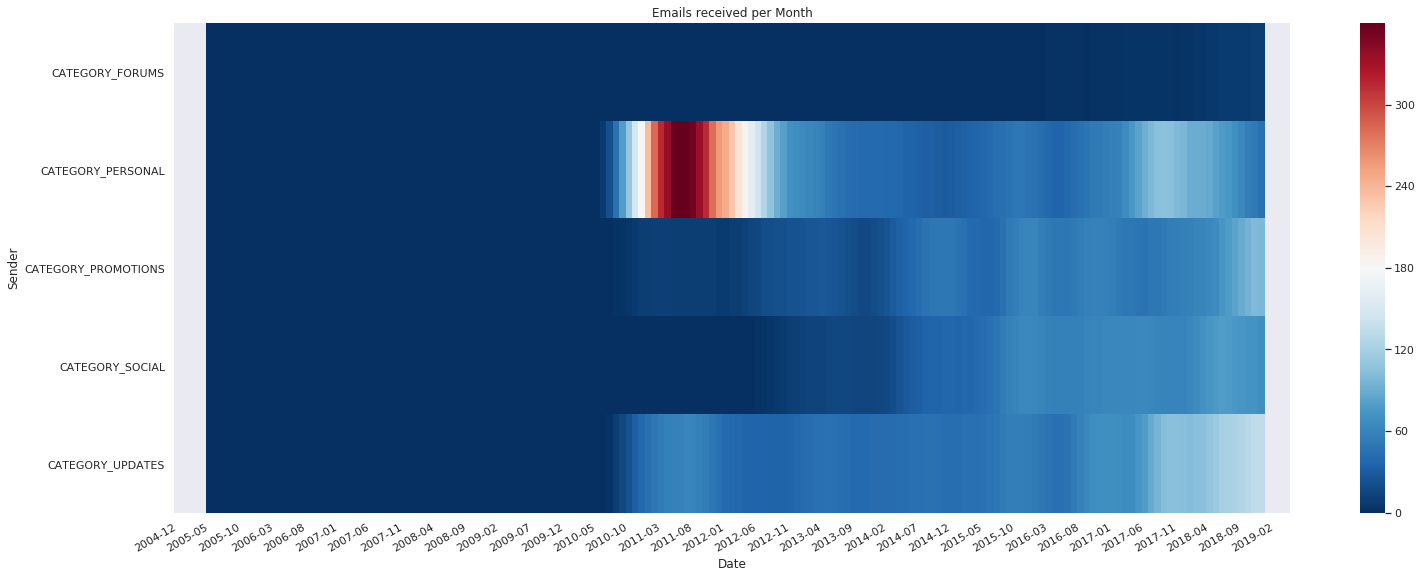

In [47]:
plot_heatmap(labels_over_time_cnt_t, 'Sender', 'Date', 'Emails received per Month')

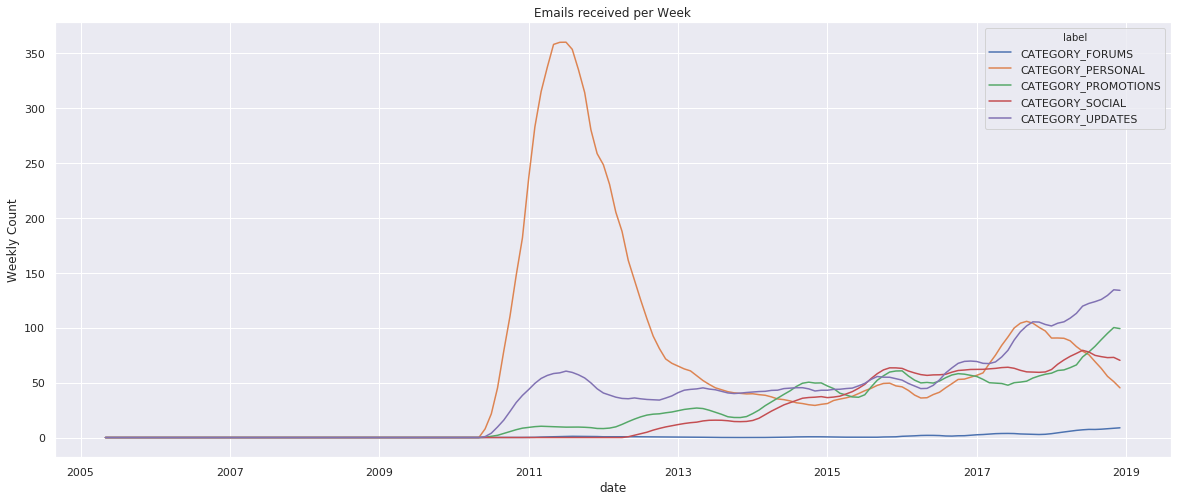

In [48]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='Date', ylabel='Weekly Count',
       title='Emails received per Week')
_ = labels_over_time_cnt.filter(like='CATEGORY', axis=1).plot(ax=ax) 

I think its clear that the number of updates, promoties and social media updates are growing fast. The actual numbers are hard to gauge as I've been consistently inconsistent in clearing my inbox of these type of emails.

## Deleting events

I'll leave the actual deletion as an exercise for the reader. You can batch delete messages with:

In [ ]:
service.users().messages().batchDelete(userId=user_id, body={
    "ids": [ # The IDs of the messages to delete.
      "A String",
    ],
  }).execute()